## 1. Setup

### 1.1 Install dependencies

In [ ]:
!pip install -U -q torch torchvision matplotlib tqdm gdown

### 1.2 Check if GPU available

In [1]:
import torch

print(torch.cuda.is_available())

False


## 2. Load data 

Meta data are stored in a json file. Read the Json file and check entries of the first two samples.

In [2]:
import json

json_file_path = 'Dataset/dataset_label.json'

with open(json_file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

### 2.1 Inspect meta data

#### 2.1.1 Inspect single labels

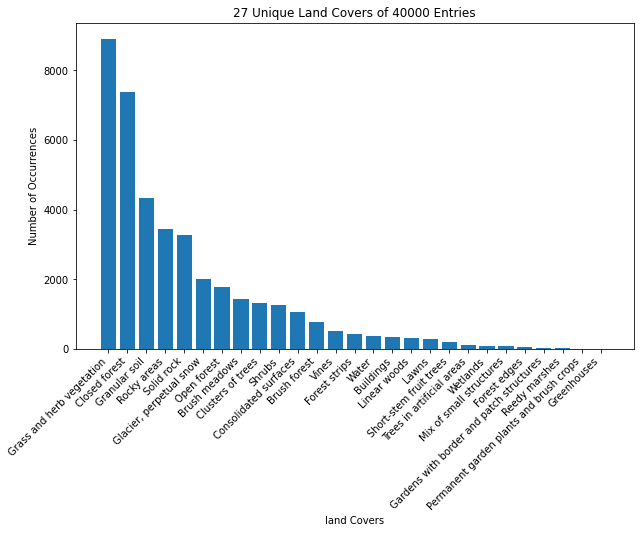

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

landcover_texts = [entry["landcover_text"] for entry in data]# if entry.get("split") == "val"])

entry_counts = Counter(landcover_texts)
entry_counts_sorted = sorted_counts = dict(sorted(entry_counts.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(10, 6))
plt.bar(list(entry_counts_sorted.keys()), list(entry_counts_sorted.values()))
plt.xticks(rotation=45, ha='right')
plt.xlabel('land Covers')
plt.ylabel('Number of Occurrences')
plt.title(f"{len(entry_counts)} Unique Land Covers of {len(landcover_texts)} Entries")
plt.show()




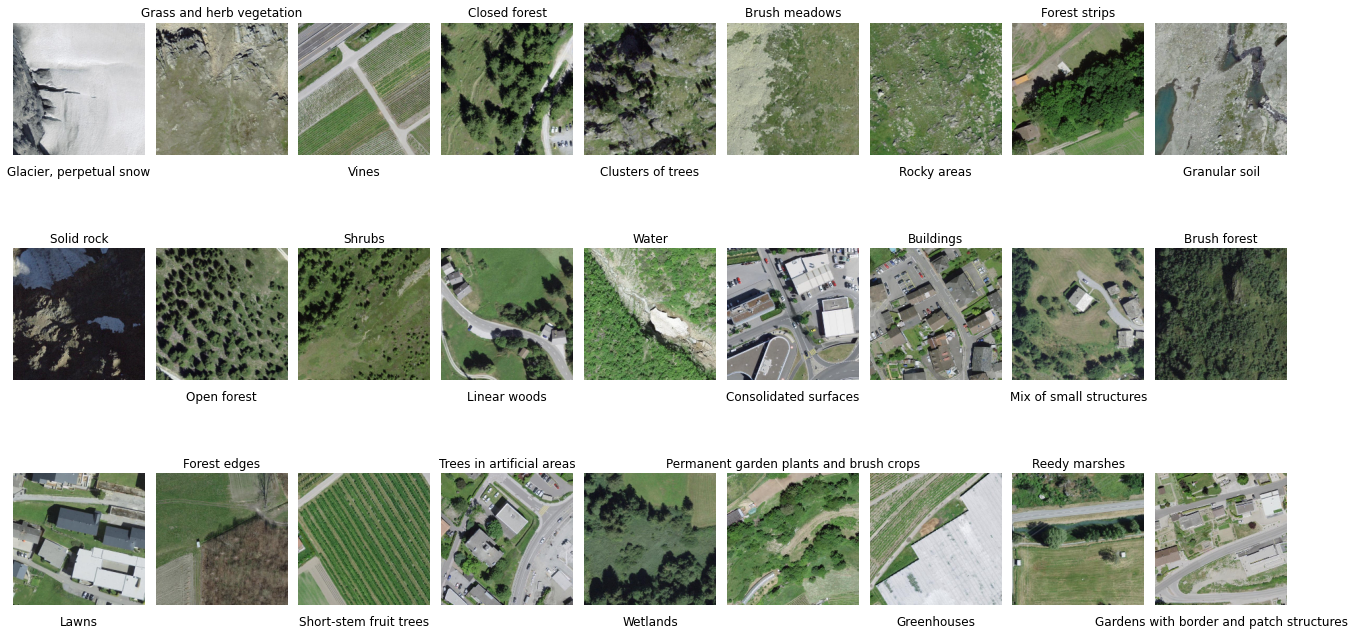

In [4]:
import os

# Preview a sample for each label using the fist encounter with the label

# Dictionary to store all first encounters of "landcover_text" with corresponding "rgb_path"
first_encounters = []

# Set to track unique "landcover_text" values
unique_landcover_texts = set()

for entry in data:
    landcover_text = entry["landcover_text"]
    if landcover_text not in unique_landcover_texts:
        unique_landcover_texts.add(landcover_text)
        first_encounters.append({"landcover_text": landcover_text, "rgb_path": entry["rgb_path"]})


# Create a subplot grid with 3 rows and 9 columns
fig, axs = plt.subplots(3, 9, figsize=(18, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through both first_encounters and axs simultaneously
counter = 0
for encounter, ax in zip(first_encounters, axs):
    counter = counter + 1
    # Read the image
    img = plt.imread(os.path.join('Dataset/rgb/', encounter["rgb_path"]))

    # Display the image
    ax.imshow(img)

    if(counter % 2): # If the landcover_text is too long, put the title below the image
        ax.set_title(encounter["landcover_text"], y = -0.2)
    else: # Otherwise, put the title above the image
        ax.set_title(encounter["landcover_text"])

    # Hide axes ticks and labels for better visualization
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### 2.1.2 Inspect multi labels

In [ ]:
# TODO

#### 2.1.3 Inspect train, validation and test splits

In [5]:
# Summary of the splits
total_entries = len(data)
train_entries = sum(entry.get("split") == "train" for entry in data)
val_entries = sum(entry.get("split") == "val" for entry in data)
test_entries = sum(entry.get("split") == "test" for entry in data)

print(f"Total entries: {total_entries}")
print(f"Entries with 'split': 'train': {train_entries} {train_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'val': {val_entries} {val_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'test': {test_entries} {test_entries/total_entries*100:.2f}%")

Total entries: 40000
Entries with 'split': 'train': 24000 60.00%
Entries with 'split': 'val': 4000 10.00%
Entries with 'split': 'test': 12000 30.00%


In [6]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(data)

from statsmodels.graphics.mosaicplot import mosaic

subset_df = (
    df[['landcover_text', 'split']]
    .groupby(['split', 'landcover_text'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
subset_df['proportion'] = subset_df.groupby('split')['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using plotly express
fig = px.bar(subset_df, x='landcover_text', y='proportion', color='split',
             title='Data splits appear to be well balanced per landcover class',
             labels={'landcover_text': 'Landcover Text', 'proportion': 'Proportion (%)'},
             category_orders={'split': sorted(subset_df['split'].unique())})

# Show the plot
fig.show()


### 2.2 Write a PyTorch Dataset Class

In [6]:
from torch.utils.data import Dataset

from PIL import Image

import glob

import numpy as np

class Valais(Dataset):
    # Labels for Land cover (NOLC04) - Federal Statistical Office | Data provided in 'Valais Dataset/landcover_labels.txt'
    LAND_COVER_MAPPING = {
    11: "Consolidated surfaces",
    12: "Buildings",
    13: "Greenhouses",
    14: "Gardens with border and patch structures",
    15: "Lawns",
    16: "Trees in artificial areas",
    17: "Mix of small structures",
    21: "Grass and herb vegetation",
    31: "Shrubs",
    32: "Brush meadows",
    33: "Short-stem fruit trees",
    34: "Vines",
    35: "Permanent garden plants and brush crops",
    40: "Tree vegetation",
    41: "Closed forest",
    42: "Forest edges",
    43: "Forest strips",
    44: "Open forest",
    45: "Brush forest",
    46: "Linear woods",
    47: "Clusters of trees",
    50: "Bare land",
    51: "Solid rock",
    52: "Granular soil",
    53: "Rocky areas",
    60: "Watery areas",
    61: "Water",
    62: "Glacier, perpetual snow",
    63: "Wetlands",
    64: "Reedy marshes"
}
    
    # Labels from Swiss Topographic Landscape Model (TLM) from Swisstopo | Data provided in 'Valais Dataset/multilabel_classes.txt'
    MULTI_LABEL_Mapping = {
    0: "background",
    1: "agricultural area",
    2: "building",
    3: "bush forest",
    4: "forest",
    5: "glacier",
    6: "lake",
    7: "pedestrian path",
    8: "public leisure area",
    9: "railways",
    10: "river",
    11: "road",
    12: "rocks",
    13: "sparse forest",
    14: "sparse rocks",
    15: "swamps",
    16: "vineyards"
}

    
    # Not necessary are images are labelled to be val, test or train
    # np.random.seed(9)
    # data_size = 10 # Number of images to be used for training, validation and testing
    # train_size = int(5/8 * data_size)
    # val_size = int(1/8 * data_size)
    
    # train_indices = np.random.choice(range(data_size), size=train_size, replace=False)
    # val_indices = np.random.choice(np.setdiff1d(range(data_size), train_indices), size = val_size, replace=False)
    # test_indices = np.setdiff1d(range(data_size), np.concatenate((train_indices, val_indices)))

    train_indices = [index for index, entry in enumerate(data) if entry.get("split") == "train"]
    val_indices = [index for index, entry in enumerate(data) if entry.get("split") == "val"]
    test_indices = [index for index, entry in enumerate(data) if entry.get("split") == "test"]

    SPLITS = {
        "train": train_indices,
        "val": val_indices,
        "test": test_indices
    }

    def __init__(self, split="train", transforms=None):
        self.transforms = transforms

        self.data = []  # list of tuples of (image path, label class)
        for labelclass in self.LAND_COVER_MAPPING:
            # get images with correct index according to dataset split
            for imgIndex in self.SPLITS[split]:
                imgName = data[imgIndex]["rgb_path"]
                imgLabel = data[imgIndex]["landcover_ids"]
                # example format: 'baseFolder/agricultural/agricultural07.tif'
                self.data.append((
                    imgName,
                    self.LAND_COVER_MAPPING[imgLabel]          # get index for label class
                ))

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, index):
        # TODO retrieve the item from self.data at position index
        imgName, label = self.data[index]

        # TODO load the image array from the imgName
        img = Image.open(os.path.join('Dataset/rgb/',imgName)).convert('RGB')

        # TODO apply transformation
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label

    


#### 2.2.1 Check if dataset class works

In [7]:
import matplotlib.pyplot as plt

# initialize the dataset (call the constructor __init__)
dataset = Valais()
print(f"dataset of length {len(dataset)}")

# plot individual samples
from ipywidgets import interact
# @interact(idx=range(len(dataset))) # Too big causing crash
@interact(idx=range(100))
def plot_sample(idx=0):
    img, label = dataset[idx]

    plt.imshow(img)

    # swaps keys and values in the dictionary UCMerced.LABEL_CLASSES
    class_mapping = {v: k for k, v in Valais.LAND_COVER_MAPPING.items()}

    plt.title(f"classid {label} ({class_mapping[label]})")

dataset of length 720000


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

### 2.3 Define custom transforms

In [49]:
# import os
# from PIL import Image
# import torch
# from torchvision import transforms

# # Define your dataset path and transform without normalization
# dataset_path = 'Valais Dataset/rgb/'
# transform = transforms.Compose([transforms.ToTensor()])

# # Get a list of image file paths
# image_paths = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.tif'))]

# # Initialize variables to accumulate the sum and sum of squares
# mean_sum = torch.zeros(3)
# std_sum = torch.zeros(3)

# # Loop through the images and compute the sum and sum of squares
# for img_path in image_paths:
#     img = Image.open(img_path)
#     img = transform(img)
#     mean_sum += img.mean(dim=[1, 2])
#     std_sum += img.std(dim=[1, 2])

# # Calculate the mean and standard deviation
# mean = mean_sum / len(image_paths)
# std = std_sum / len(image_paths)

# print("Calculated mean:", mean)
# print("Calculated std:", std)


Calculated mean: tensor([0.4215, 0.4603, 0.3775])
Calculated std: tensor([0.1379, 0.1375, 0.1301])


In [8]:
import torchvision.transforms as T
import numpy as np

# mean and standard deviation of the dataset
mean=torch.tensor([0.4215, 0.4603, 0.3775])
std=torch.tensor([0.1379, 0.1375, 0.1301])

# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
    T.RandomResizedCrop((180, 180)), # Original size is 200x200
    T.RandomGrayscale(p=0.1),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.RandomPosterize(bits=4, p=0.2),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

  T.Resize((200, 200)),
  T.ToTensor(),
  normalize
])

# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  # T.Resize((200, 200)), # No need they are 200 x 200 anyways
  T.ToTensor(),
  normalize
])

#### 2.3.1 Check if transforms work

[(-0.5, 199.5, 199.5, -0.5), (-0.5, 199.5, 199.5, -0.5)]

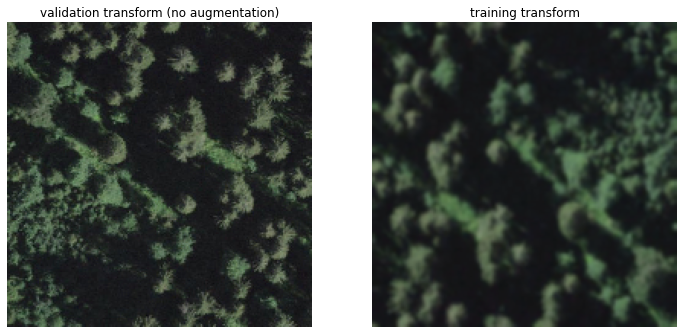

In [9]:
dataset_index = 320

img, label = dataset[dataset_index]

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(unnormalize(transforms_val(img)).permute(1,2,0))
axs[0].set_title("validation transform (no augmentation)")

axs[1].imshow(unnormalize(transforms_train(img)).permute(1,2,0))
axs[1].set_title("training transform")
[ax.axis("off") for ax in axs] # removes ticks

### 2.3 Create train and validation data loaders

In [10]:
train_dataset = Valais(split = 'train' , transforms=transforms_train)
val_dataset = Valais(split = 'val', transforms=transforms_val)

## 3. Train model